In [62]:
# Problem Statement 2
# An Insurance firm providing tour insurance is facing higher claim frequency. 
# The management decides to collect data from the past few years. 
# You are assigned the task to make a model which predicts the claim status and provide recommendations to management. 
# Use CART, RF & ANN and compare the models' performances in train and test sets.

In [63]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [64]:
df2 = pd.read_csv("insurance_part2_data-2.csv")

In [65]:
# Checking the data

In [66]:
df2.head()

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,C2B,Airlines,No,0.70,Online,7,2.51,Customised Plan,ASIA
1,36,EPX,Travel Agency,No,0.00,Online,34,20.00,Customised Plan,ASIA
2,39,CWT,Travel Agency,No,5.94,Online,3,9.90,Customised Plan,Americas
3,36,EPX,Travel Agency,No,0.00,Online,4,26.00,Cancellation Plan,ASIA
4,33,JZI,Airlines,No,6.30,Online,53,18.00,Bronze Plan,ASIA


In [67]:
df2.Claimed.value_counts(normalize = True)*100

No     69.2
Yes    30.8
Name: Claimed, dtype: float64

In [68]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           3000 non-null   int64  
 1   Agency_Code   3000 non-null   object 
 2   Type          3000 non-null   object 
 3   Claimed       3000 non-null   object 
 4   Commision     3000 non-null   float64
 5   Channel       3000 non-null   object 
 6   Duration      3000 non-null   int64  
 7   Sales         3000 non-null   float64
 8   Product Name  3000 non-null   object 
 9   Destination   3000 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 234.5+ KB


In [69]:
# Are there any missing values ?
df2.isnull().sum()

Age             0
Agency_Code     0
Type            0
Claimed         0
Commision       0
Channel         0
Duration        0
Sales           0
Product Name    0
Destination     0
dtype: int64

In [70]:
df2.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,3000.0,NaN,NaN,NaN,38.091,10.463518,8.0,32.0,36.0,42.0,84.0
Agency_Code,3000,4,EPX,1365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,3000,2,Travel Agency,1837,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Claimed,3000,2,No,2076,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Commision,3000.0,NaN,NaN,NaN,14.529203,25.481455,0.0,0.0,4.63,17.235,210.21
Channel,3000,2,Online,2954,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Duration,3000.0,NaN,NaN,NaN,70.001333,134.053313,-1.0,11.0,26.5,63.0,4580.0
Sales,3000.0,NaN,NaN,NaN,60.249913,70.733954,0.0,20.0,33.0,69.0,539.0
Product Name,3000,5,Customised Plan,1136,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Destination,3000,3,ASIA,2465,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
#Check correlations with "Age"-feature
df2_corr = df2.corr(method='kendall').unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df2_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df2_corr[df2_corr['Feature 1'] == 'Claimed']

,Feature 1,Feature 2,Correlation Coefficient
7,Claimed,Claimed,1.000000
21,Claimed,Commision,0.294172
23,Claimed,Sales,0.262421
27,Claimed,Product Name,0.197263
34,Claimed,Duration,0.146877
67,Claimed,Channel,-0.013646
77,Claimed,Destination,-0.038362
80,Claimed,Age,-0.062749
90,Claimed,Type,-0.328268
94,Claimed,Agency_Code,-0.386112


In [71]:
# Geting unique counts of all Nominal Variables

In [72]:
df2.columns

Index(['Age', 'Agency_Code', 'Type', 'Claimed', 'Commision', 'Channel',
       'Duration', 'Sales', 'Product Name', 'Destination'],
      dtype='object')

In [73]:
for column in df2[['Agency_Code', 'Claimed', 'Channel', 'Type', 'Product Name', 'Destination' ]]:
    print(column.upper(),': ',df2[column].nunique())
    print(df2[column].value_counts().sort_values())
    print('\n')

AGENCY_CODE :  4
JZI     239
CWT     472
C2B     924
EPX    1365
Name: Agency_Code, dtype: int64


CLAIMED :  2
Yes     924
No     2076
Name: Claimed, dtype: int64


CHANNEL :  2
Offline      46
Online     2954
Name: Channel, dtype: int64


TYPE :  2
Airlines         1163
Travel Agency    1837
Name: Type, dtype: int64


PRODUCT NAME :  5
Gold Plan             109
Silver Plan           427
Bronze Plan           650
Cancellation Plan     678
Customised Plan      1136
Name: Product Name, dtype: int64


DESTINATION :  3
EUROPE       215
Americas     320
ASIA        2465
Name: Destination, dtype: int64




In [74]:
print('Shape: ',df2.shape)

Shape:  (3000, 10)


In [75]:
# Check for duplicate data

In [76]:
# Are there any duplicates ?
dups = df2.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
df2[dups]

Number of duplicate rows = 139


,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
63,30,C2B,Airlines,Yes,15.0,Online,27,60.0,Bronze Plan,ASIA
329,36,EPX,Travel Agency,No,0.0,Online,5,20.0,Customised Plan,ASIA
407,36,EPX,Travel Agency,No,0.0,Online,11,19.0,Cancellation Plan,ASIA
411,35,EPX,Travel Agency,No,0.0,Online,2,20.0,Customised Plan,ASIA
422,36,EPX,Travel Agency,No,0.0,Online,5,20.0,Customised Plan,ASIA
...,...,...,...,...,...,...,...,...,...,...
2940,36,EPX,Travel Agency,No,0.0,Online,8,10.0,Cancellation Plan,ASIA
2947,36,EPX,Travel Agency,No,0.0,Online,10,28.0,Customised Plan,ASIA
2952,36,EPX,Travel Agency,No,0.0,Online,2,10.0,Cancellation Plan,ASIA
2962,36,EPX,Travel Agency,No,0.0,Online,4,20.0,Customised Plan,ASIA


In [78]:
df2.drop_duplicates(inplace=True)

In [79]:
dups = df2.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
print(df2.shape)

Number of duplicate rows = 0
(2861, 10)


In [80]:
# Removing rows having 0 and -1 from 'Duration' column

In [81]:
df2.drop(df2[df2.Duration==0].index, inplace=True)

In [82]:
df2.drop(df2[df2.Duration==-1].index, inplace=True)

In [83]:
print(df2.shape)

(2858, 10)


In [84]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2858 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           2858 non-null   int64  
 1   Agency_Code   2858 non-null   object 
 2   Type          2858 non-null   object 
 3   Claimed       2858 non-null   object 
 4   Commision     2858 non-null   float64
 5   Channel       2858 non-null   object 
 6   Duration      2858 non-null   int64  
 7   Sales         2858 non-null   float64
 8   Product Name  2858 non-null   object 
 9   Destination   2858 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 245.6+ KB


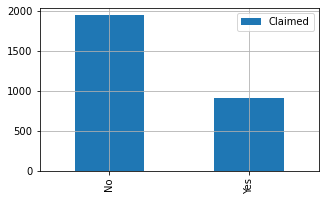

In [85]:
plt.figure(figsize=(5,3))
df2['Claimed'].value_counts().plot(kind='bar')
plt.legend()
plt.grid()
plt.show()

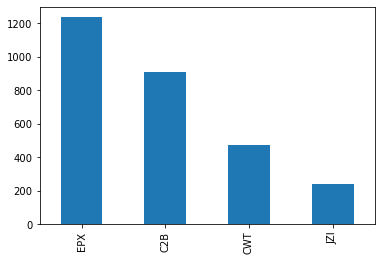

In [86]:
df2['Agency_Code'].value_counts().plot(kind='bar');

In [87]:
df2.head()

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,C2B,Airlines,No,0.70,Online,7,2.51,Customised Plan,ASIA
1,36,EPX,Travel Agency,No,0.00,Online,34,20.00,Customised Plan,ASIA
2,39,CWT,Travel Agency,No,5.94,Online,3,9.90,Customised Plan,Americas
3,36,EPX,Travel Agency,No,0.00,Online,4,26.00,Cancellation Plan,ASIA
4,33,JZI,Airlines,No,6.30,Online,53,18.00,Bronze Plan,ASIA


C:\Users\Aditya Rishi\Anaconda\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Aditya Rishi\Anaconda\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Aditya Rishi\Anaconda\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

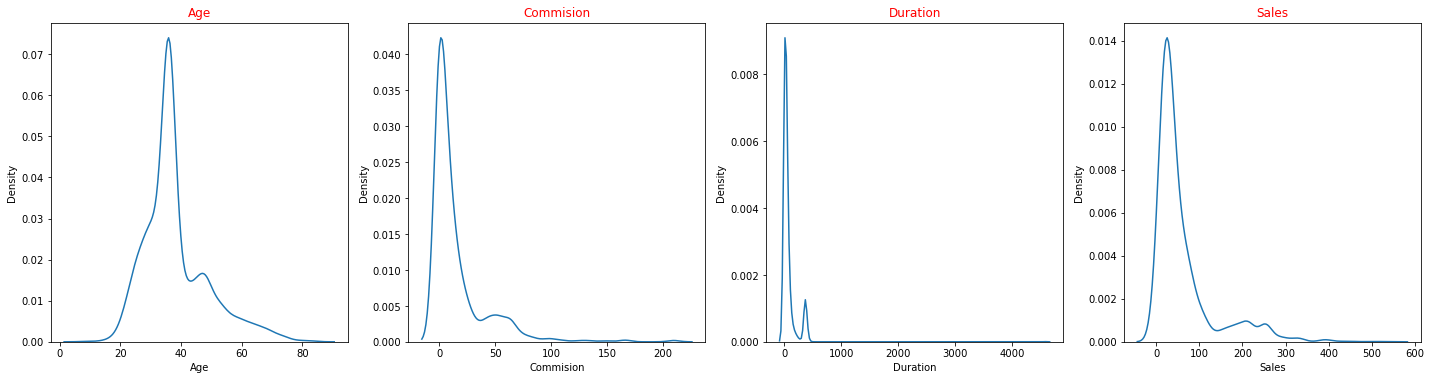

In [88]:
data_plot=df2[['Age', 'Commision', 'Duration', 'Sales',]]
fig=plt.figure(figsize=(20,20))
for i in range(0,len(data_plot.columns)):
    ax=fig.add_subplot(4,4,i+1)
    sns.distplot(data_plot[data_plot.columns[i]],hist=False)
    ax.set_title(data_plot.columns[i],color='Red')
plt.tight_layout()
plt.show()

In [89]:
# Checking pairwise distribution of the continuous variables

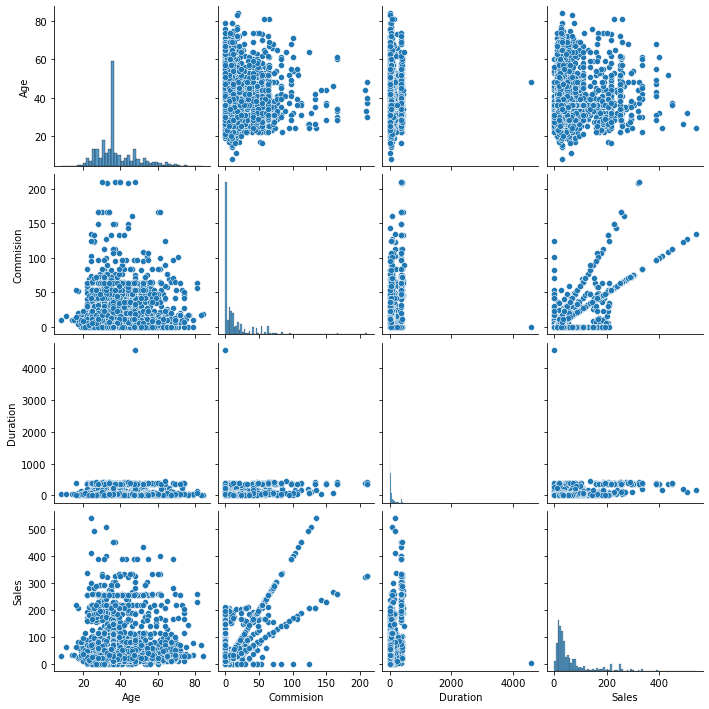

In [90]:
sns.pairplot(df2[['Age', 'Commision', 'Duration', 'Sales',]]);

In [91]:
# Checking for Correlations

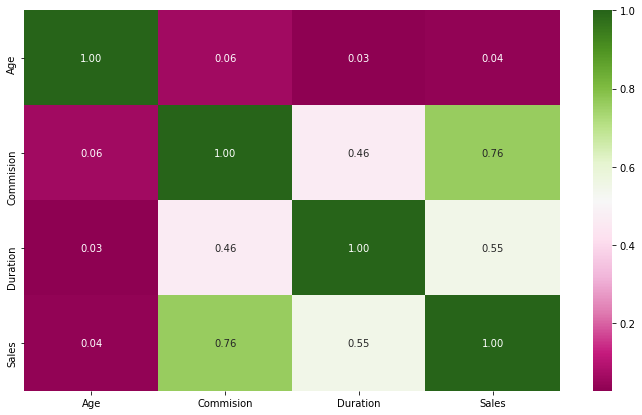

In [92]:
plt.figure(figsize=(12,7))
sns.heatmap(df2[['Age', 'Commision', 'Duration', 'Sales',]].corr(),annot=True,fmt='.2f',cmap='PiYG')
plt.show()

In [93]:
# There are all positive correlations between variables, and no negative correlations. Commission and sales have a high positive correaltion
# Overall the magnitude of correlations between the variables are very less.

In [94]:
# Checking for outliers

In [95]:
def boxplot_comparison(df, hue=None): # This user-defined function makes boxplots
    """Given dataframe, generate boxplots of numeric data"""
    print("\nTo check: \nPresence of outliers")

    columns = df.select_dtypes(include=np.number).columns
    figure = plt.figure(figsize=(20, 10))
    figure.add_subplot(1, len(columns), 1)
    for index, col in enumerate(columns):
        if index > 0:
            figure.add_subplot(1, len(columns), index + 1)
        sns.boxplot(y=col, data=df, boxprops={'facecolor': 'None'})
    figure.tight_layout()
    plt.show()


To check: 
Presence of outliers


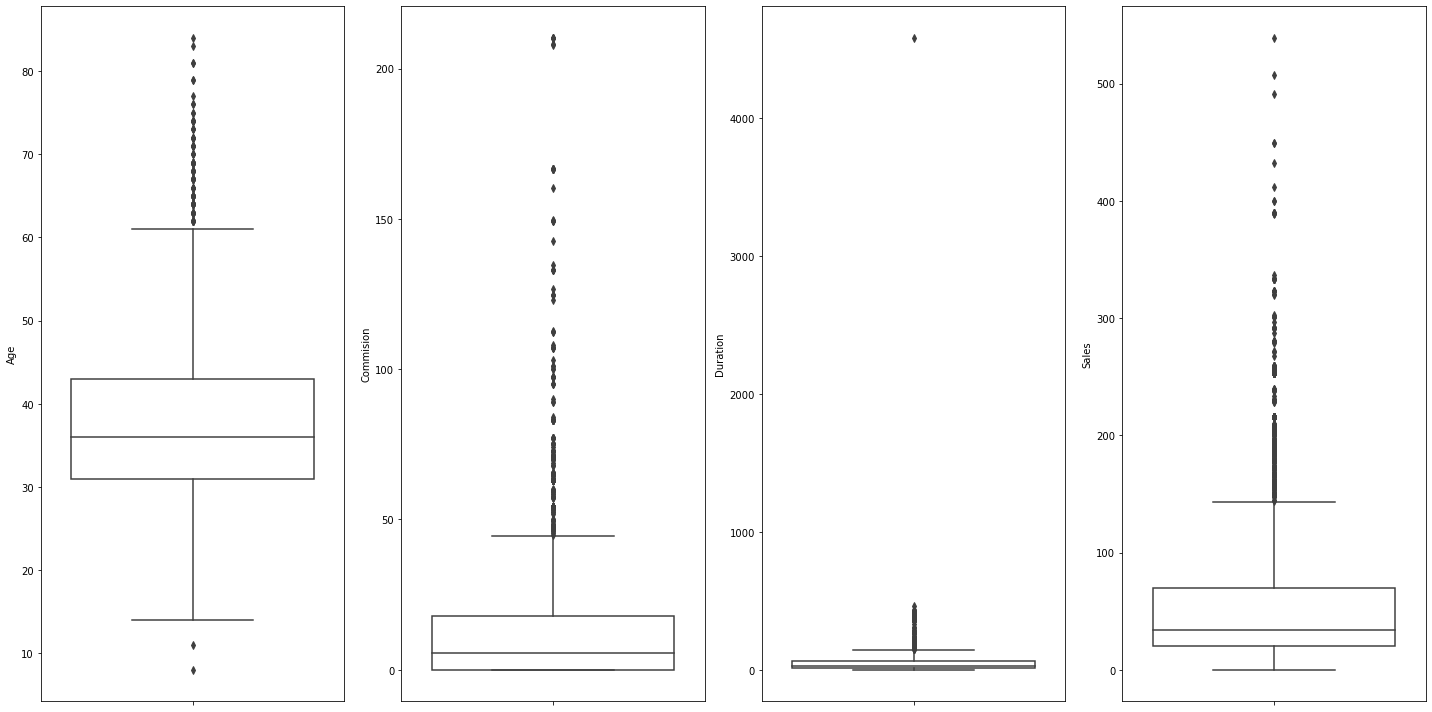

In [96]:
boxplot_comparison(df2[['Age', 'Commision', 'Duration', 'Sales',]])

<AxesSubplot:>

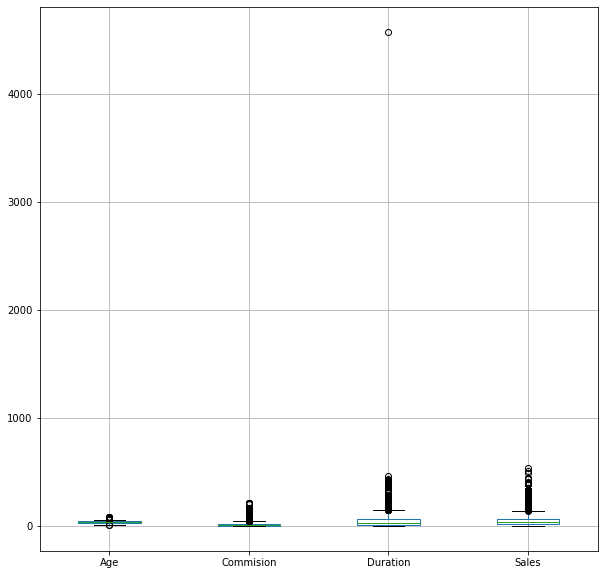

In [97]:
# construct box plot for continuous variables
plt.figure(figsize=(10,10))
df2[['Age', 'Commision', 'Duration', 'Sales',]].boxplot(vert=1)

In [98]:
# There are outliers in all 4 numerical variables. Random Forest and ANN can handle the outliers.
# However, Outliers are treated for now, by replacing it with upper/lower values.

In [99]:
def remove_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range

In [100]:
l1,u1=remove_outlier(df2['Age'])
df2['Age']=np.where(df2['Age']>u1,u1,df2['Age'])
df2['Age']=np.where(df2['Age']<l1,l1,df2['Age'])

In [101]:
l1,u1=remove_outlier(df2['Commision'])
df2['Commision']=np.where(df2['Commision']>u1,u1,df2['Commision'])
df2['Commision']=np.where(df2['Commision']<l1,l1,df2['Commision'])

In [102]:
l1,u1=remove_outlier(df2['Duration'])
df2['Duration']=np.where(df2['Duration']>u1,u1,df2['Duration'])
df2['Duration']=np.where(df2['Duration']<l1,l1,df2['Duration'])

In [105]:
l1,u1=remove_outlier(df2['Sales'])
df2['Sales']=np.where(df2['Sales']>u1,u1,df2['Sales'])
df2['Sales']=np.where(df2['Sales']<l1,l1,df2['Sales'])


To check: 
Presence of outliers


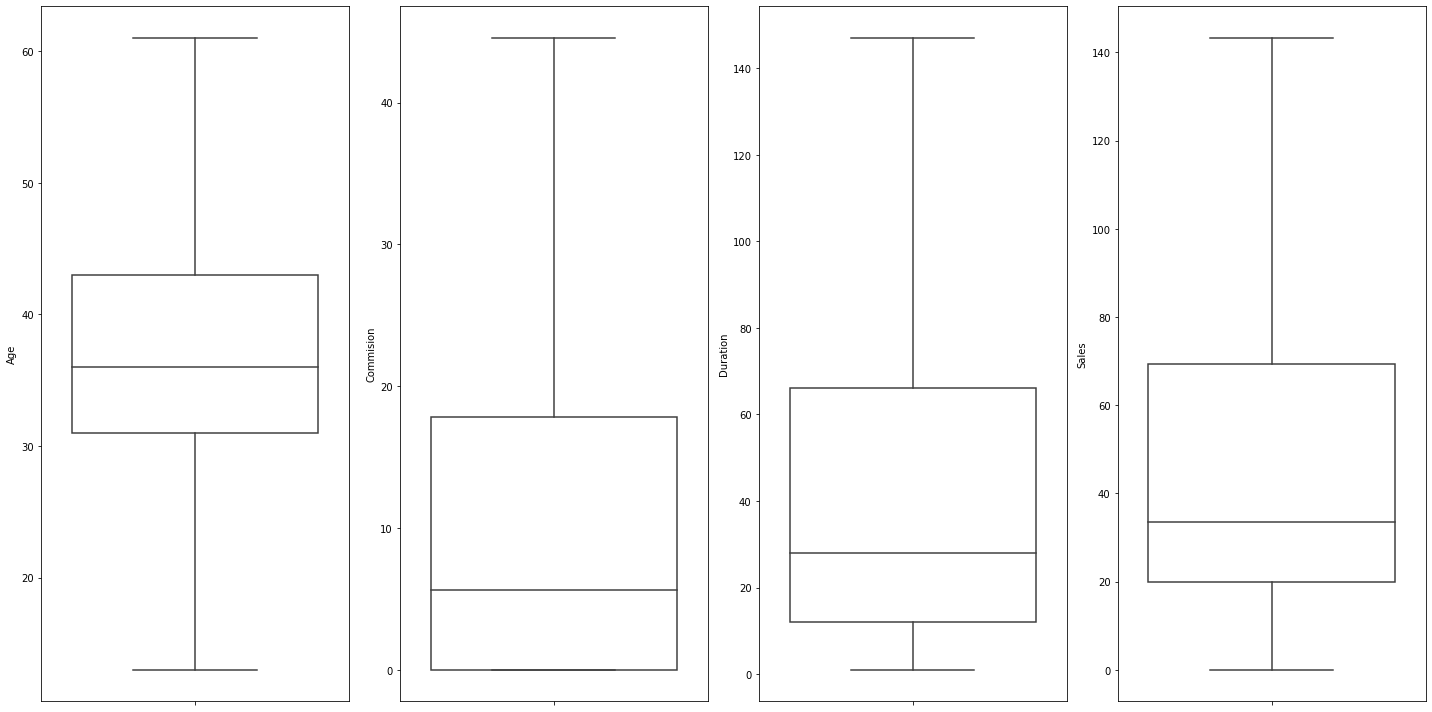

In [106]:
boxplot_comparison(df2[['Age', 'Commision', 'Duration', 'Sales',]])

<AxesSubplot:>

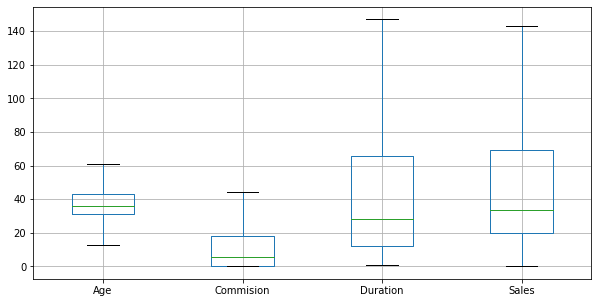

In [107]:
plt.figure(figsize=(10,5))
df2[['Age', 'Commision', 'Duration', 'Sales',]].boxplot(vert=1)

In [108]:
df2c = df2
for feature in df2c.columns: 
    if df2c[feature].dtype == 'object': 
        print('\n')
        print('feature:',feature)
        print(pd.Categorical(df2c[feature].unique()))
        print(pd.Categorical(df2c[feature].unique()).codes)
        df2c[feature] = pd.Categorical(df2c[feature]).codes



feature: Agency_Code
['C2B', 'EPX', 'CWT', 'JZI']
Categories (4, object): ['C2B', 'CWT', 'EPX', 'JZI']
[0 2 1 3]


feature: Type
['Airlines', 'Travel Agency']
Categories (2, object): ['Airlines', 'Travel Agency']
[0 1]


feature: Claimed
['No', 'Yes']
Categories (2, object): ['No', 'Yes']
[0 1]


feature: Channel
['Online', 'Offline']
Categories (2, object): ['Offline', 'Online']
[1 0]


feature: Product Name
['Customised Plan', 'Cancellation Plan', 'Bronze Plan', 'Silver Plan', 'Gold Plan']
Categories (5, object): ['Bronze Plan', 'Cancellation Plan', 'Customised Plan', 'Gold Plan', 'Silver Plan']
[2 1 0 4 3]


feature: Destination
['ASIA', 'Americas', 'EUROPE']
Categories (3, object): ['ASIA', 'Americas', 'EUROPE']
[0 1 2]


In [109]:
# Proportion of 1s and 0s

In [49]:
df2c.Claimed.value_counts(normalize=True)

0    0.680196
1    0.319804
Name: Claimed, dtype: float64

In [110]:
# There is no issue of class imbalance here as we have reasonable proportions in both the classes

In [111]:
# Extracting the target column into separate vectors for training set and test set

In [52]:
X = df2c.drop("Claimed" , axis=1)
y = df2c.pop("Claimed")
X.head()

,Age,Agency_Code,Type,Commision,Channel,Duration,Sales,Product Name,Destination
0,48.0,0,0,0.70,1,7.0,2.51,2,0
1,36.0,2,1,0.00,1,34.0,20.00,2,0
2,39.0,1,1,5.94,1,3.0,9.90,2,1
3,36.0,2,1,0.00,1,4.0,26.00,1,0
4,33.0,3,0,6.30,1,53.0,18.00,0,0


In [53]:
# Splitting data into training and test set

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, train_labels, test_labels = train_test_split(X, y, test_size=.30, random_state=1)

In [55]:
train_labels.value_counts(normalize=True)*100

0    67.25
1    32.75
Name: Claimed, dtype: float64

In [56]:
test_labels.value_counts(normalize=True)*100

0    69.81352
1    30.18648
Name: Claimed, dtype: float64

0    67.25
1    32.75
Name: Claimed, dtype: float64


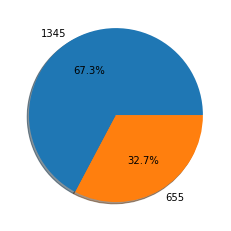

In [58]:
plt.pie(train_labels.value_counts(), labels=train_labels.value_counts().values, autopct='%1.1f%%', shadow=True);
print(train_labels.value_counts(normalize=True)*100)

0    69.81352
1    30.18648
Name: Claimed, dtype: float64


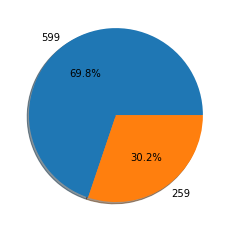

In [59]:
plt.pie(test_labels.value_counts(), labels=test_labels.value_counts().values, autopct='%1.1f%%', shadow=True);
print(test_labels.value_counts(normalize=True)*100)

In [71]:
# Since the distribution of values of target variable is verified and found close to equal,
# it can be concluded that the data set is properly split

In [72]:
# Checking the dimensions of the training and test data

In [73]:
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('train_labels',train_labels.shape)
print('test_labels',test_labels.shape)

X_train (2000, 9)
X_test (858, 9)
train_labels (2000,)
test_labels (858,)


In [74]:
# Building a Decision Tree Classifier

In [75]:
param_grid = {
    'criterion': ['gini'],
    'max_depth': [3, 4, 5],
    'min_samples_leaf': [20,25],
    'min_samples_split': [40,50]
}

dtcl = DecisionTreeClassifier(random_state=1)

grid_search = GridSearchCV(estimator = dtcl, param_grid = param_grid, cv = 5)

In [76]:
grid_search.fit(X_train, train_labels)
print(grid_search.best_params_)

{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 20, 'min_samples_split': 40}


In [77]:
best_grid = grid_search.best_estimator_
best_grid

DecisionTreeClassifier(max_depth=4, min_samples_leaf=20, min_samples_split=40,
                       random_state=1)

In [78]:
#dtcl.fit(X_train,train_labels)
from sklearn import tree

train_char_label = ['No', 'Yes']
tree_regularized = open('Claimed_TreeReg_File.dot','w')
dot_data = tree.export_graphviz(best_grid, out_file= tree_regularized , feature_names = list(X_train), class_names = list(train_char_label))

tree_regularized.close()
dot_data

In [79]:
# Variable Importance

In [80]:
print (pd.DataFrame(best_grid.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values('Imp',ascending=False))

                   Imp
Agency_Code   0.595163
Sales         0.242283
Product Name  0.082964
Commision     0.049578
Destination   0.013126
Age           0.009048
Duration      0.007838
Type          0.000000
Channel       0.000000


In [81]:
# Predicting on Training and Test dataset

In [82]:
ytrain_predict = best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

In [83]:
# Getting the Predicted Classes and Probabilities

In [84]:
ytest_predict
ytest_predict_prob=best_grid.predict_proba(X_test)
ytest_predict_prob
pd.DataFrame(ytest_predict_prob).head()

,0,1
0,0.725301,0.274699
1,0.409266,0.590734
2,0.922432,0.077568
3,0.725301,0.274699
4,0.210084,0.789916


In [85]:
# Model Evaluation
# AUC and ROC for the training data

AUC: 0.812


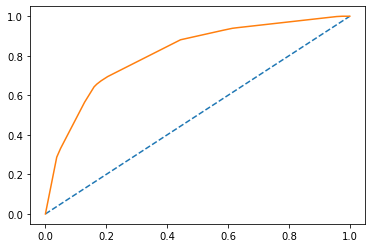

In [86]:
# predict probabilities
probs = best_grid.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
cart_train_auc = roc_auc_score(train_labels, probs)
print('AUC: %.3f' % cart_train_auc)
# calculate roc curve
cart_train_fpr, cart_train_tpr, cart_train_thresholds = roc_curve(train_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(cart_train_fpr, cart_train_tpr)

In [87]:
# AUC and ROC for the test data

AUC: 0.807


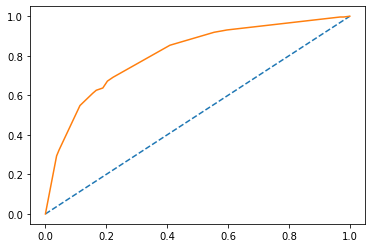

In [88]:
# predict probabilities
probs = best_grid.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
cart_test_auc = roc_auc_score(test_labels, probs)
print('AUC: %.3f' % cart_test_auc)
# calculate roc curve
cart_test_fpr, cart_test_tpr, cart_testthresholds = roc_curve(test_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(cart_test_fpr, cart_test_tpr)

In [89]:
# Confusion Matrix for the training data

In [90]:
confusion_matrix(train_labels, ytrain_predict)

array([[1130,  215],
       [ 234,  421]], dtype=int64)

In [91]:
#Train Data Accuracy
cart_train_acc=best_grid.score(X_train,train_labels) 
cart_train_acc

0.7755

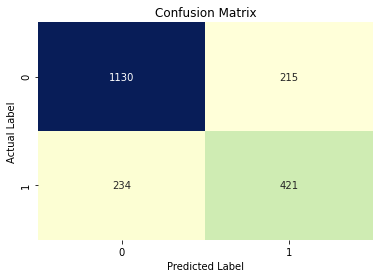

In [92]:
sns.heatmap(confusion_matrix(train_labels,ytrain_predict),annot=True, fmt='d', cbar=False,cmap='YlGnBu')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [93]:
print(classification_report(train_labels, ytrain_predict))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1345
           1       0.66      0.64      0.65       655

    accuracy                           0.78      2000
   macro avg       0.75      0.74      0.74      2000
weighted avg       0.77      0.78      0.77      2000



In [94]:
cart_metrics=classification_report(train_labels, ytrain_predict,output_dict=True)
df=pd.DataFrame(cart_metrics).transpose()
cart_train_f1=round(df.loc["1"][2],2)
cart_train_recall=round(df.loc["1"][1],2)
cart_train_precision=round(df.loc["1"][0],2)
print ('cart_train_precision ',cart_train_precision*100,'%')
print ('cart_train_recall ',cart_train_recall*100,'%')
print ('cart_train_f1 ',cart_train_f1*100,'%')

cart_train_precision  66.0 %
cart_train_recall  64.0 %
cart_train_f1  65.0 %


In [95]:
# Confusion Matrix for test data

In [96]:
confusion_matrix(test_labels, ytest_predict)

array([[506,  93],
       [101, 158]], dtype=int64)

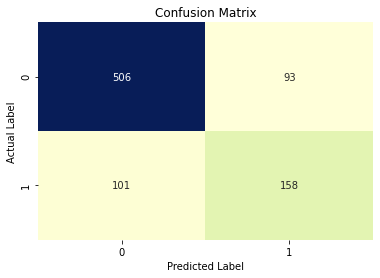

In [97]:
sns.heatmap(confusion_matrix(test_labels,ytest_predict),annot=True, fmt='d', cbar=False,cmap='YlGnBu')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [98]:
#Test Data Accuracy
cart_test_acc=best_grid.score(X_test,test_labels)
cart_test_acc

0.7738927738927739

In [99]:
print(classification_report(test_labels, ytest_predict))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       599
           1       0.63      0.61      0.62       259

    accuracy                           0.77       858
   macro avg       0.73      0.73      0.73       858
weighted avg       0.77      0.77      0.77       858



In [100]:
cart_metrics=classification_report(test_labels, ytest_predict,output_dict=True)
df=pd.DataFrame(cart_metrics).transpose()
cart_test_precision=round(df.loc["1"][0],2)
cart_test_recall=round(df.loc["1"][1],2)
cart_test_f1=round(df.loc["1"][2],2)
print ('cart_test_precision ',cart_test_precision*100,'%')
print ('cart_test_recall ',cart_test_recall*100,'%')
print ('cart_test_f1 ',cart_test_f1*100,'%')

cart_test_precision  63.0 %
cart_test_recall  61.0 %
cart_test_f1  62.0 %


In [101]:
# Building a Random Forest Classifier

In [102]:
# Grid Search for finding out the optimal values for the hyper parameters

In [103]:
param_grid = {
    'max_depth': [4,5,7],
    'max_features': [4,5,6],
    'min_samples_leaf': [2,3],
    'min_samples_split': [25,30,35],
    'n_estimators': [30,40,50]
}

rfcl = RandomForestClassifier(random_state=1)

grid_search = GridSearchCV(estimator = rfcl, param_grid = param_grid, cv = 5)

In [104]:
grid_search.fit(X_train, train_labels)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [4, 5, 7], 'max_features': [4, 5, 6],
                         'min_samples_leaf': [2, 3],
                         'min_samples_split': [25, 30, 35],
                         'n_estimators': [30, 40, 50]})

In [105]:
grid_search.best_params_

{'max_depth': 5,
 'max_features': 6,
 'min_samples_leaf': 3,
 'min_samples_split': 30,
 'n_estimators': 50}

In [106]:
best_grid = grid_search.best_estimator_

In [107]:
best_grid

RandomForestClassifier(max_depth=5, max_features=6, min_samples_leaf=3,
                       min_samples_split=30, n_estimators=50, random_state=1)

In [108]:
# Predicting the Training and Testing data

In [109]:
ytrain_predict = best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

In [110]:
# RF Model Performance Evaluation on Training data

In [111]:
confusion_matrix(train_labels,ytrain_predict)

array([[1180,  165],
       [ 254,  401]], dtype=int64)

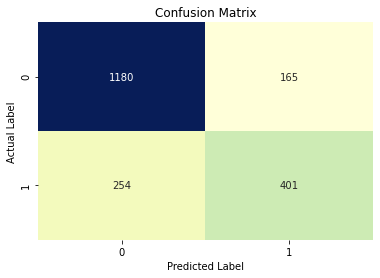

In [112]:
sns.heatmap(confusion_matrix(train_labels,ytrain_predict),annot=True, fmt='d', cbar=False,cmap='YlGnBu')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [113]:
rf_train_acc=best_grid.score(X_train,train_labels) 
rf_train_acc

0.7905

In [114]:
print(classification_report(train_labels,ytrain_predict))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1345
           1       0.71      0.61      0.66       655

    accuracy                           0.79      2000
   macro avg       0.77      0.74      0.75      2000
weighted avg       0.79      0.79      0.79      2000



In [115]:
rf_metrics=classification_report(train_labels, ytrain_predict,output_dict=True)
df=pd.DataFrame(rf_metrics).transpose()
rf_train_precision=round(df.loc["1"][0],2)
rf_train_recall=round(df.loc["1"][1],2)
rf_train_f1=round(df.loc["1"][2],2)
print ('rf_train_precision ',rf_train_precision*100,'%')
print ('rf_train_recall ',rf_train_recall*100,'%')
print ('rf_train_f1 ',rf_train_f1*100,'%')

rf_train_precision  71.0 %
rf_train_recall  61.0 %
rf_train_f1  66.0 %


Area under Curve is 0.8391628593319902


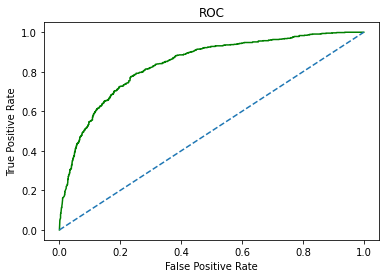

In [116]:
rf_train_fpr, rf_train_tpr,_=roc_curve(train_labels,best_grid.predict_proba(X_train)[:,1])
plt.plot(rf_train_fpr,rf_train_tpr,color='green')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
rf_train_auc=roc_auc_score(train_labels,best_grid.predict_proba(X_train)[:,1])
print('Area under Curve is', rf_train_auc)

In [117]:
# RF Model Performance Evaluation on Test data

In [118]:
confusion_matrix(test_labels,ytest_predict)

array([[535,  64],
       [106, 153]], dtype=int64)

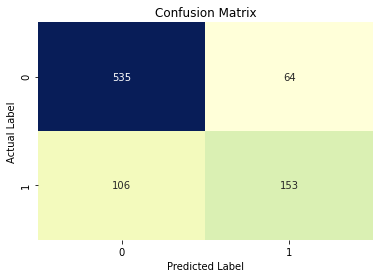

In [119]:
sns.heatmap(confusion_matrix(test_labels,ytest_predict),annot=True, fmt='d', cbar=False,cmap='YlGnBu')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [120]:
rf_test_acc=best_grid.score(X_test,test_labels)
rf_test_acc

0.8018648018648019

In [121]:
print(classification_report(test_labels,ytest_predict))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       599
           1       0.71      0.59      0.64       259

    accuracy                           0.80       858
   macro avg       0.77      0.74      0.75       858
weighted avg       0.80      0.80      0.80       858



In [122]:
rf_metrics=classification_report(test_labels, ytest_predict,output_dict=True)
df=pd.DataFrame(rf_metrics).transpose()
rf_test_precision=round(df.loc["1"][0],2)
rf_test_recall=round(df.loc["1"][1],2)
rf_test_f1=round(df.loc["1"][2],2)
print ('rf_test_precision ',rf_test_precision*100,'%')
print ('rf_test_recall ',rf_test_recall*100,'%')
print ('rf_test_f1 ',rf_test_f1*100,'%')

rf_test_precision  71.0 %
rf_test_recall  59.0 %
rf_test_f1  64.0 %


Area under Curve is 0.8310504637716658


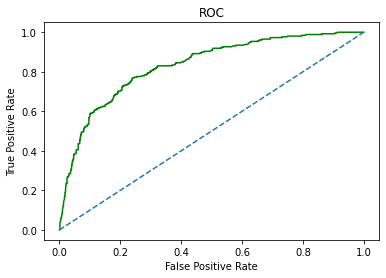

In [123]:
rf_test_fpr, rf_test_tpr,_=roc_curve(test_labels,best_grid.predict_proba(X_test)[:,1])
plt.plot(rf_test_fpr,rf_test_tpr,color='green')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
rf_test_auc=roc_auc_score(test_labels,best_grid.predict_proba(X_test)[:,1])
print('Area under Curve is', rf_test_auc)

In [124]:
# Variable Importance
print (pd.DataFrame(best_grid.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values('Imp',ascending=False))

                   Imp
Agency_Code   0.383377
Product Name  0.210363
Sales         0.180724
Commision     0.071267
Duration      0.064096
Age           0.046798
Type          0.024806
Destination   0.011152
Channel       0.007417


In [125]:
# Building a Neural Network Classifier

In [126]:
param_grid = {
    'hidden_layer_sizes': [50,100,200], # 50, 200
    'max_iter': [500,1000], #5000,2500
    'solver': ['adam', 'sgd'], #sgd
    'tol': [0.01], 
}

nncl = MLPClassifier(random_state=1)

grid_search = GridSearchCV(estimator = nncl, param_grid = param_grid, cv = 10, verbose=True)

In [127]:
grid_search.fit(X_train, train_labels)
grid_search.best_params_
#{'hidden_layer_sizes': 100, 'max_iter': 2500, 'solver': 'adam', 'tol': 0.01}

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   25.6s finished


{'hidden_layer_sizes': 200, 'max_iter': 500, 'solver': 'adam', 'tol': 0.01}

In [128]:
best_grid = grid_search.best_estimator_
best_grid

MLPClassifier(hidden_layer_sizes=200, max_iter=500, random_state=1, tol=0.01)

In [129]:
nncl = MLPClassifier(hidden_layer_sizes=200, max_iter=500,
                     solver='adam', verbose=True,  random_state=1,tol=0.01)

In [130]:
nncl.fit(X_train,train_labels)
ytestpred = nncl.predict(X_test)

Iteration 1, loss = 1.72630617
Iteration 2, loss = 0.75920240
Iteration 3, loss = 0.70832831
Iteration 4, loss = 0.62140761
Iteration 5, loss = 0.57752373
Iteration 6, loss = 0.56152579
Iteration 7, loss = 0.55053419
Iteration 8, loss = 0.54161520
Iteration 9, loss = 0.53303863
Iteration 10, loss = 0.52712767
Iteration 11, loss = 0.52577205
Iteration 12, loss = 0.51805559
Iteration 13, loss = 0.51540118
Iteration 14, loss = 0.50936968
Iteration 15, loss = 0.50792795
Iteration 16, loss = 0.50871863
Iteration 17, loss = 0.50876450
Iteration 18, loss = 0.50742996
Training loss did not improve more than tol=0.010000 for 10 consecutive epochs. Stopping.


In [131]:
# Predicting the Training and Testing data

In [132]:
ytrain_predict = best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

In [133]:
nncl.fit(X_train,train_labels)
ytestpred = nncl.predict(X_test)

Iteration 1, loss = 1.72630617
Iteration 2, loss = 0.75920240
Iteration 3, loss = 0.70832831
Iteration 4, loss = 0.62140761
Iteration 5, loss = 0.57752373
Iteration 6, loss = 0.56152579
Iteration 7, loss = 0.55053419
Iteration 8, loss = 0.54161520
Iteration 9, loss = 0.53303863
Iteration 10, loss = 0.52712767
Iteration 11, loss = 0.52577205
Iteration 12, loss = 0.51805559
Iteration 13, loss = 0.51540118
Iteration 14, loss = 0.50936968
Iteration 15, loss = 0.50792795
Iteration 16, loss = 0.50871863
Iteration 17, loss = 0.50876450
Iteration 18, loss = 0.50742996
Training loss did not improve more than tol=0.010000 for 10 consecutive epochs. Stopping.


In [134]:
# NN Model Performance Evaluation on Training data

In [135]:
confusion_matrix(train_labels,ytrain_predict)

array([[1206,  139],
       [ 335,  320]], dtype=int64)

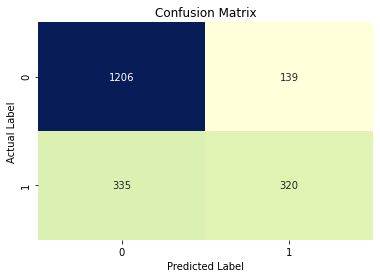

In [136]:
sns.heatmap(confusion_matrix(train_labels,ytrain_predict),annot=True, fmt='d', cbar=False,cmap='YlGnBu')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [137]:
nn_train_acc=best_grid.score(X_train,train_labels) 
nn_train_acc

0.763

In [138]:
print(classification_report(train_labels,ytrain_predict))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84      1345
           1       0.70      0.49      0.57       655

    accuracy                           0.76      2000
   macro avg       0.74      0.69      0.71      2000
weighted avg       0.75      0.76      0.75      2000



In [139]:

nn_metrics=classification_report(train_labels, ytrain_predict,output_dict=True)
df=pd.DataFrame(nn_metrics).transpose()
nn_train_precision=round(df.loc["1"][0],2)
nn_train_recall=round(df.loc["1"][1],2)
nn_train_f1=round(df.loc["1"][2],2)
print ('nn_train_precision ',nn_train_precision)
print ('nn_train_recall ',nn_train_recall)
print ('nn_train_f1 ',nn_train_f1)

nn_train_precision  0.7
nn_train_recall  0.49
nn_train_f1  0.57


Area under Curve is 0.8001452935667869


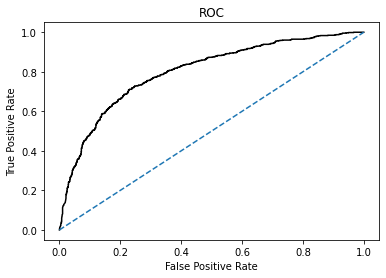

In [140]:
nn_train_fpr, nn_train_tpr,_=roc_curve(train_labels,best_grid.predict_proba(X_train)[:,1])
plt.plot(nn_train_fpr,nn_train_tpr,color='black')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
nn_train_auc=roc_auc_score(train_labels,best_grid.predict_proba(X_train)[:,1])
print('Area under Curve is', nn_train_auc)

In [141]:
# NN Model Performance Evaluation on Test data

In [142]:
confusion_matrix(test_labels,ytest_predict)

array([[546,  53],
       [135, 124]], dtype=int64)

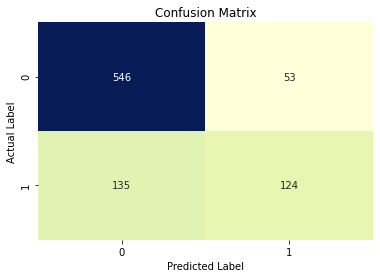

In [143]:
sns.heatmap(confusion_matrix(test_labels,ytest_predict),annot=True, fmt='d', cbar=False,cmap='YlGnBu')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [144]:
nn_test_acc=best_grid.score(X_test,test_labels)
nn_test_acc

0.7808857808857809

In [145]:
# print(classification_report(test_labels,ytest_predict))

In [146]:
nn_metrics=classification_report(test_labels, ytest_predict,output_dict=True)
df=pd.DataFrame(nn_metrics).transpose()
nn_test_precision=round(df.loc["1"][0],2)
nn_test_recall=round(df.loc["1"][1],2)
nn_test_f1=round(df.loc["1"][2],2)
print ('nn_test_precision ',nn_test_precision)
print ('nn_test_recall ',nn_test_recall)
print ('nn_test_f1 ',nn_test_f1)

nn_test_precision  0.7
nn_test_recall  0.48
nn_test_f1  0.57


Area under Curve is 0.8114392713724934


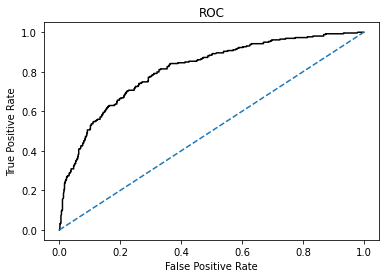

In [147]:
nn_test_fpr, nn_test_tpr,_=roc_curve(test_labels,best_grid.predict_proba(X_test)[:,1])
plt.plot(nn_test_fpr,nn_test_tpr,color='black')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
nn_test_auc=roc_auc_score(test_labels,best_grid.predict_proba(X_test)[:,1])
print('Area under Curve is', nn_test_auc)

In [148]:
best_grid.score

<bound method ClassifierMixin.score of MLPClassifier(hidden_layer_sizes=200, max_iter=500, random_state=1, tol=0.01)>

In [149]:
# Final Conclusion
# Comparison of the performance metrics from the 3 models

In [150]:
index=['Accuracy', 'AUC', 'Recall','Precision','F1 Score']
data = pd.DataFrame({'CART Train':[cart_train_acc,cart_train_auc,cart_train_recall,cart_train_precision,cart_train_f1],
        'CART Test':[cart_test_acc,cart_test_auc,cart_test_recall,cart_test_precision,cart_test_f1],
       'Random Forest Train':[rf_train_acc,rf_train_auc,rf_train_recall,rf_train_precision,rf_train_f1],
        'Random Forest Test':[rf_test_acc,rf_test_auc,rf_test_recall,rf_test_precision,rf_test_f1],
       'Neural Network Train':[nn_train_acc,nn_train_auc,nn_train_recall,nn_train_precision,nn_train_f1],
        'Neural Network Test':[nn_test_acc,nn_test_auc,nn_test_recall,nn_test_precision,nn_test_f1]},index=index)
round(data,2)

,CART Train,CART Test,Random Forest Train,Random Forest Test,Neural Network Train,Neural Network Test
Accuracy,0.78,0.77,0.79,0.80,0.76,0.78
AUC,0.81,0.81,0.84,0.83,0.80,0.81
Recall,0.64,0.61,0.61,0.59,0.49,0.48
Precision,0.66,0.63,0.71,0.71,0.70,0.70
F1 Score,0.65,0.62,0.66,0.64,0.57,0.57


In [151]:
# ROC Curve for the 3 models on the Training data

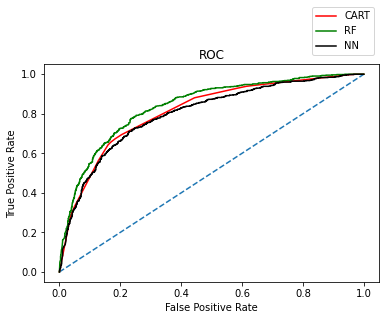

In [152]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(cart_train_fpr, cart_train_tpr,color='red',label="CART")
plt.plot(rf_train_fpr,rf_train_tpr,color='green',label="RF")
plt.plot(nn_train_fpr,nn_train_tpr,color='black',label="NN")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower right')

In [153]:
# ROC Curve for the 3 models on the Test data

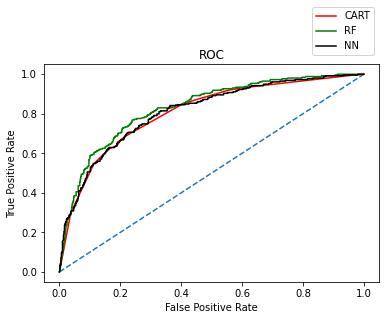

In [154]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(cart_test_fpr, cart_test_tpr,color='red',label="CART")
plt.plot(rf_test_fpr,rf_test_tpr,color='green',label="RF")
plt.plot(nn_test_fpr,nn_test_tpr,color='black',label="NN")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower right')

In [155]:
# Out of the 3 models, Random Forest has slightly better performance than the Cart and Neural network model
# Overall all the 3 models are reasonaly stable enough to be used for making any future predictions. 
# From Cart and Random Forest Model, the variable Agency_Code is found to be the most useful feature
# for predicting claim status.